# Logistic Regression Example
### 2019-04-24
Code taken from : https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

## Dataset
The dataset comes from the UCI Machine Learning repository, and it is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (1/0) to a term deposit (variable y). The dataset can be downloaded from https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
data=pd.read_csv('banking.csv',header=0)
data = data.dropna()
print(data.shape)
list(data.columns)

(41188, 21)


['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'y']

In [3]:
data.education.unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [4]:
#Let us group “basic.4y”, “basic.9y” and “basic.6y” together and call them “basic”. 
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [5]:
data.education.unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

# Data Exploration

In [6]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

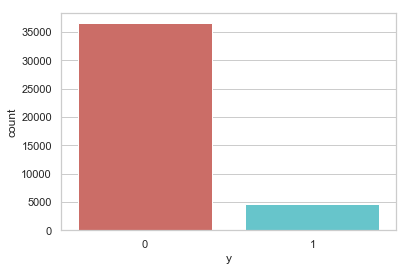

In [7]:
sns.countplot(x='y',data=data, palette='hls')
plt.savefig("count_plot.png")

In [8]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.73458288821988
percentage of subscription 11.265417111780131


### These classes are unbalanced, we need to fix this
Come back to this later

In [9]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


Observations:

* The average age of customers who bought the term deposit is higher than that of the customers who didn’t.
* The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
* Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

In [10]:
#We can calculate categorical means for other categorical variables such as education and marital status 
# to get a more detailed sense of our data.
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [11]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [12]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


## Visualizations

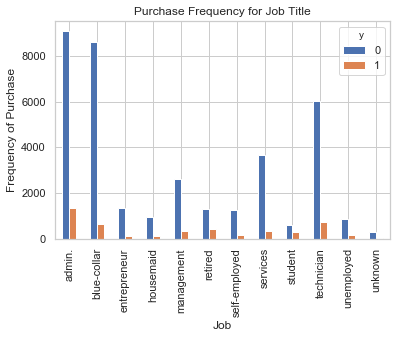

In [13]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

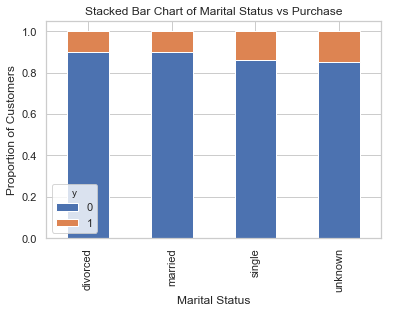

In [14]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

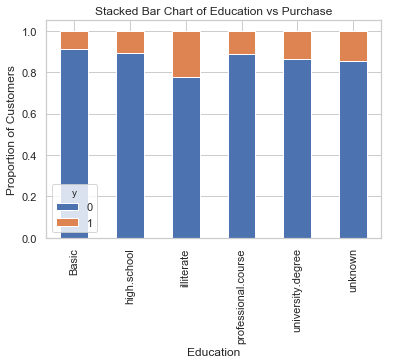

In [15]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

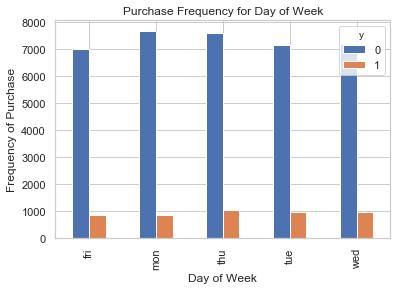

In [16]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_dayofweek_bar')

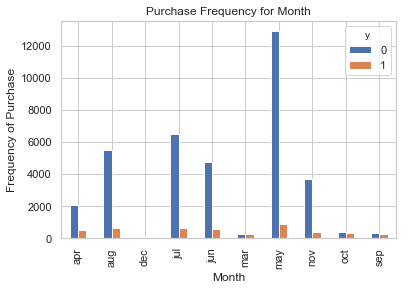

In [17]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

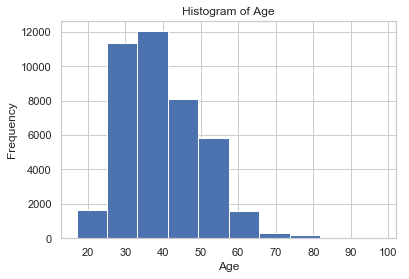

In [18]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

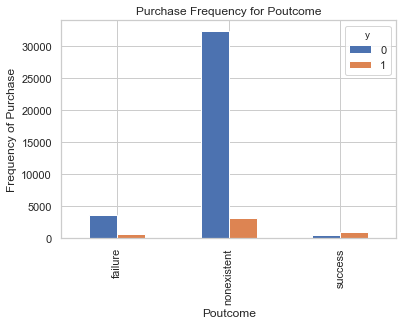

In [19]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

## Create dummy variables

In [20]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [21]:
to_keep

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'y',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_Basic',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'default_no',
 'default_unknown',
 'default_yes',
 'housing_no',
 'housing_unknown',
 'housing_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_fri',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_

In [22]:
data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

The original author used SMOTE to oversample the unbalanced classes and recursive feature elimination to regularize. I opted for a simpler approach (since we only have 1 hour) and accomplish both of these in the sklearn api.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [25]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.y

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [24]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model.logistic:

class LogisticRegression(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.linear_model.base.SparseCoefMixin)
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the cross-
 |  entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 'sag' and 'lbfgs' solvers. It can handle
 |  both dense and sparse input. Use C-ordered arrays or CSR matrices
 |  containing 64-bit floats for optimal performance; any other input format
 |  will be converted (and copied).
 |  
 |  The 'newton-cg', 'sag', and 'lbfgs' solve

In [27]:
logreg = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    C=0.25 #make this smaller (close to 0) to increase regularization strength
)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

### Predicting the test set results and calculating accuracy

In [28]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


#### Confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[9401, 1580],
       [ 159, 1217]], dtype=int64)

#### Other metrics

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92     10981
           1       0.44      0.88      0.58      1376

   micro avg       0.86      0.86      0.86     12357
   macro avg       0.71      0.87      0.75     12357
weighted avg       0.92      0.86      0.88     12357



To quote from http://scikit-lehttp://scikit-learn.org/stable/index.htmlarn.org/stable/index.html:

* The **precision** is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

* The **recall** is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

* The **F1 score** can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

* The **support** is the number of occurrences of each class in y_test.

#### ROC curve

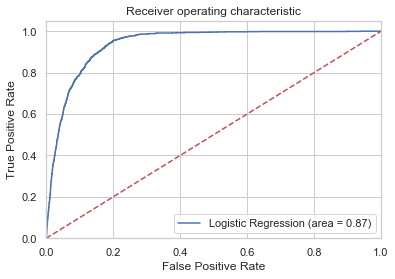

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

https://en.wikipedia.org/wiki/Receiver_operating_characteristic
<br>The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

The Jupyter notebook used to make this post is available here. I would be pleased to receive feedback or questions on any of the above.    

## Logistic regression with H2O
I don't like how SKlearn doesn't calculate many important stats for the features. 
Statsmodels does a better job of this, but doesn't allow for class sampling

In [33]:
import h2o
h2o.init()
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)56-b12)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\MASTED~1\AppData\Local\Temp\tmpubgygiqy
  JVM stdout: C:\Users\MASTED~1\AppData\Local\Temp\tmpubgygiqy\h2o_MasteD17189_started_from_python.out
  JVM stderr: C:\Users\MASTED~1\AppData\Local\Temp\tmpubgygiqy\h2o_MasteD17189_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,06 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,3 months and 5 days
H2O cluster name:,H2O_from_python_MasteD17189_5di92w
H2O cluster total nodes:,1
H2O cluster free memory:,3.531 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [34]:
#import into h2o frames
data_finalh2o= h2o.H2OFrame(data_final)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [35]:
data_finalh2o['y']=data_finalh2o['y'].asfactor()

In [36]:
x=data_finalh2o.columns
x.remove('y')

In [37]:
train,test=data_finalh2o.split_frame(ratios=[0.70], seed=413)

In [38]:
help(H2OGeneralizedLinearEstimator)

Help on class H2OGeneralizedLinearEstimator in module h2o.estimators.glm:

class H2OGeneralizedLinearEstimator(h2o.estimators.estimator_base.H2OEstimator)
 |  Generalized Linear Modeling
 |  
 |  Fits a generalized linear model, specified by a response variable, a set of predictors, and a
 |  description of the error distribution.
 |  
 |  A subclass of :class:`ModelBase` is returned. The specific subclass depends on the machine learning task
 |  at hand (if it's binomial classification, then an H2OBinomialModel is returned, if it's regression then a
 |  H2ORegressionModel is returned). The default print-out of the models is shown, but further GLM-specific
 |  information can be queried out of the object. Upon completion of the GLM, the resulting object has
 |  coefficients, normalized coefficients, residual/null deviance, aic, and a host of model metrics including
 |  MSE, AUC (for logistic regression), degrees of freedom, and confusion matrices.
 |  
 |  Method resolution order:
 |  

In [39]:
glm_model_noreg = H2OGeneralizedLinearEstimator(
    family= "binomial",
    balance_classes=True,
    lambda_ = 0, #p-values only computed with no regularization
    compute_p_values = True,
    remove_collinear_columns=True
)

In [40]:
glm_model_noreg.train(
    x,'y', training_frame= train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [41]:
glm_model_noreg.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24644644601266816: 


,0,1,Error,Rate
0,23942.0,1802.0,0.07,(1802.0/25744.0)
1,942.0,2251.0,0.295,(942.0/3193.0)
Total,24884.0,4053.0,0.0948,(2744.0/28937.0)


In [42]:
glm_model_noreg._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,std_error,z_value,p_value,standardized_coefficients
0,Intercept,-223.244413,403.157645,-0.553740,5.797570e-01,-3.177340
1,age,0.002539,0.002913,0.871352,3.835618e-01,0.026470
2,duration,0.004734,0.000090,52.650179,0.000000e+00,1.216305
3,campaign,-0.050357,0.014151,-3.558464,3.730297e-04,-0.138486
4,pdays,-0.000678,0.000266,-2.543142,1.098605e-02,-0.126863
5,previous,-0.032114,0.070183,-0.457569,6.472622e-01,-0.015950
6,emp_var_rate,-1.766867,0.170630,-10.354945,0.000000e+00,-2.770747
7,cons_price_idx,2.089208,0.306219,6.822585,8.941625e-12,1.207981
8,cons_conf_idx,0.017572,0.009409,1.867505,6.183105e-02,0.081042
9,euribor3m,0.465370,0.156895,2.966133,3.015696e-03,0.806406


#### now do one with regularization

In [43]:
glm_model_reg = H2OGeneralizedLinearEstimator(
    family= "binomial",
    balance_classes=True,
    lambda_ = 0.01, 
    compute_p_values = False,
    remove_collinear_columns=True
)

In [44]:
glm_model_reg.train(
    x,'y', training_frame= train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [45]:
coef_out=glm_model_reg._model_json['output']['coefficients_table'].as_data_frame()
coef_out[np.abs(coef_out.coefficients)>0].sort_values(by='coefficients', ascending=False)

,names,coefficients,standardized_coefficients
61,poutcome_success,2.002994,0.360710
33,default_no,1.499899,0.610015
49,month_mar,1.334521,0.154660
34,default_unknown,1.188954,0.483494
7,cons_price_idx,0.828964,0.479308
60,poutcome_nonexistent,0.664405,0.228376
42,contact_cellular,0.516817,0.248851
46,month_dec,0.231880,0.015328
19,job_student,0.231618,0.032516
16,job_retired,0.219138,0.043743


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


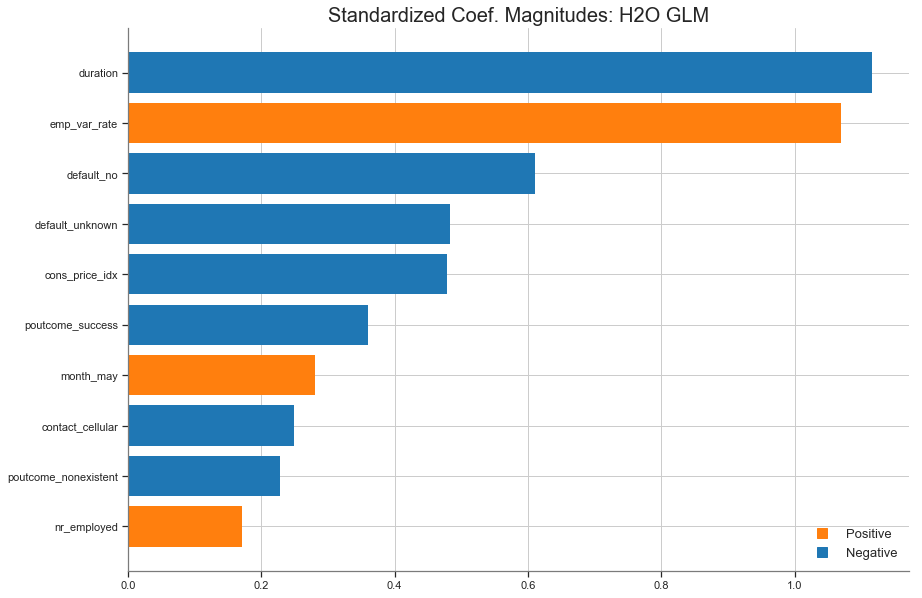

In [46]:
# plot the top 10
glm_model_reg.std_coef_plot(10)

In [47]:
h2o.cluster().shutdown()

H2O session _sid_b719 closed.
